In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utils import plot_confusion_matrix

In [2]:
filename = 'output/COLRECT_pivoted.pickle'

df_filtered = pd.read_pickle(filename)

df_filtered.head()

,PUBCSNUM,BENBORDCOUNT,MDXRECMP,AGE_DX,MALIGCOUNT,SRV_TIME_MON,YEAR_DX,REC_NO,REG__0000001501,REG__0000001502,...,AYASITERWHO__52,AYASITERWHO__55,AYASITERWHO__56,AYASITERWHO__99,INTPRIM__0,INTPRIM__1,INTPRIM__9,CSSCHEMA__25,CSSCHEMA__26,CSSCHEMA__36
9,07000085,00,02,077,04,0047,2007,02,0,1,...,0,0,0,0,0,1,0,0,1,0
32,07000321,00,09,086,02,0039,2012,01,0,1,...,0,0,0,0,0,1,0,1,0,0
44,07000411,00,07,088,02,0038,2006,01,0,1,...,0,0,0,0,0,1,0,1,0,0
57,07000510,00,05,082,03,0016,2011,02,0,1,...,0,0,0,0,0,1,0,1,0,0
73,07000635,00,05,083,02,0067,2010,01,0,1,...,0,0,0,0,0,1,0,1,0,0


In [3]:
# Prepare training

x_df = df_filtered.drop(columns=['PUBCSNUM', 'SRV_TIME_MON'])
X = x_df.values.astype(np.float32)
y_cont = df_filtered.SRV_TIME_MON.values.astype(np.float32)
y = np.where(y_cont > 60, 1, 0)

print(f'Feature shape: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Feature shape: (277984, 1049)


In [5]:
# Feature selection (Step 1. RF training)

print('Start training random forest...')
model_for_fs = RandomForestClassifier(n_jobs=8, n_estimators=10, random_state=42)
model_for_fs.fit(X_train, y_train)

Start training random forest...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
# Feature selection (Step 2. create feature selector)

feature_selector = SelectFromModel(model_for_fs, prefit=True)

feature_selected_column_names = x_df.columns[feature_selector.get_support()].values

with open('feature_selected_column_info.txt', 'w') as f:
    f.write(' '.join(feature_selected_column_names))
    
with open('feature_selected_column_info_simple.txt', 'w') as f:
    simple = []
    for name in feature_selected_column_names:
        simple.append(name.split('_')[0])
    simple = list(set(simple))
    f.write(' '.join(simple))
    

In [18]:
feature_importance = model_for_fs.feature_importances_[feature_selector.get_support()]

tmp = [(fn, fi) for fn, fi in zip(feature_selected_column_names, feature_importance)]
tmp_sorted = sorted(tmp, key=lambda tup: tup[1], reverse=True)

with open('feature_importance.txt', 'w') as f:
    for fn, fi in tmp_sorted:
        line = f'{fn}, {fi}\n'
        f.write(line)

In [8]:
# Feature selection (Step 2. transform Xs)

X_train_fs = feature_selector.transform(X_train)
X_test_fs = feature_selector.transform(X_test)

print(f'Number of selected features: {X_train_fs.shape[1]}')

Number of selected features: 146


In [9]:
# Scaling

scalar = MinMaxScaler()
scalar.fit(X_train_fs)

X_train_scaled = scalar.transform(X_train_fs)
X_test_scaled = scalar.transform(X_test_fs)

joblib.dump(scalar, 'scalar.pickle')

['scalar.pickle']

In [10]:
# Logistic Regression

print('Start training logistic regression...')
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)

print('Saving logistic regression model...')
joblib.dump(model_lr, 'model_lr.pickle')

Start training logistic regression...


/Users/doyubkim/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Saving logistic regression model...


['model_lr.pickle']

Training set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.84      0.88      0.86    131888
      > 5yrs       0.72      0.66      0.69     62700

   micro avg       0.81      0.81      0.81    194588
   macro avg       0.78      0.77      0.77    194588
weighted avg       0.80      0.81      0.80    194588

Test set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.84      0.88      0.86     56342
      > 5yrs       0.72      0.66      0.69     27054

   micro avg       0.81      0.81      0.81     83396
   macro avg       0.78      0.77      0.77     83396
weighted avg       0.80      0.81      0.80     83396

Confusion matrix, without normalization


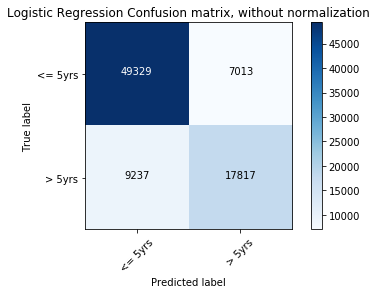

Normalized confusion matrix


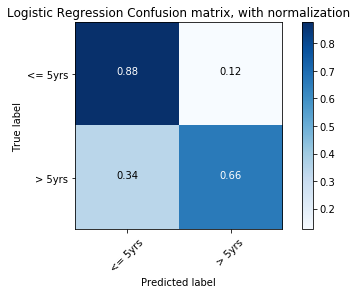

In [11]:
target_names = ['<= 5yrs', '> 5yrs']

def eval(model, name, Xtr=X_train_scaled, Xts=X_test_scaled):
    print('Training set evaluation')
    y_train_pred = model.predict(Xtr)
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    print('Test set evaluation')
    y_test_pred = model.predict(Xts)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                          title=f'{name} Confusion matrix, without normalization')
    plt.show()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title=f'{name} Confusion matrix, with normalization')
    plt.show()
    
eval(model_lr, 'Logistic Regression')

In [14]:
# Random Forest

print('Start training random forest...')
model_rf = RandomForestClassifier(n_estimators=100,
                                  n_jobs=8, 
                                  random_state=42)
model_rf.fit(X_train_scaled, y_train)

print('Saving random forest model...')
joblib.dump(model_rf, 'model_rf.pickle')

Start training random forest...
Saving random forest model...


['model_rf.pickle']

Training set evaluation
              precision    recall  f1-score   support

     <= 5yrs       1.00      1.00      1.00    131888
      > 5yrs       1.00      1.00      1.00     62700

   micro avg       1.00      1.00      1.00    194588
   macro avg       1.00      1.00      1.00    194588
weighted avg       1.00      1.00      1.00    194588

Test set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.89      0.86      0.88     56342
      > 5yrs       0.73      0.78      0.76     27054

   micro avg       0.84      0.84      0.84     83396
   macro avg       0.81      0.82      0.82     83396
weighted avg       0.84      0.84      0.84     83396

Confusion matrix, without normalization


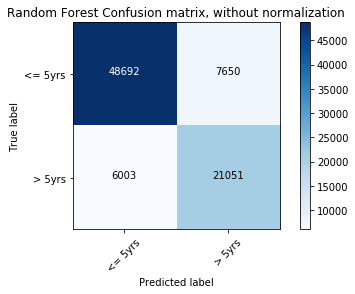

Normalized confusion matrix


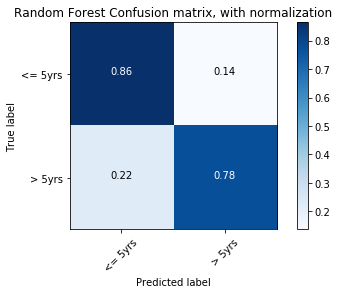

In [15]:
eval(model_rf, 'Random Forest')

In [16]:
# Linear SVM

print('Start training linear SVM...')
model_lsvm = LinearSVC(random_state=42)
model_lsvm.fit(X_train_scaled, y_train)

print('Saving Linear SVM model...')
joblib.dump(model_lsvm, 'model_lsvm.pickle')

Start training linear SVM...
Saving Linear SVM model...


['model_lsvm.pickle']

Training set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.85      0.87      0.86    131888
      > 5yrs       0.72      0.67      0.69     62700

   micro avg       0.81      0.81      0.81    194588
   macro avg       0.78      0.77      0.78    194588
weighted avg       0.81      0.81      0.81    194588

Test set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.85      0.87      0.86     56342
      > 5yrs       0.72      0.67      0.69     27054

   micro avg       0.81      0.81      0.81     83396
   macro avg       0.78      0.77      0.78     83396
weighted avg       0.80      0.81      0.81     83396

Confusion matrix, without normalization


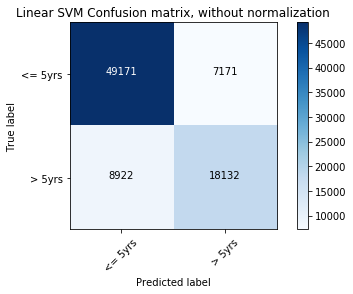

Normalized confusion matrix


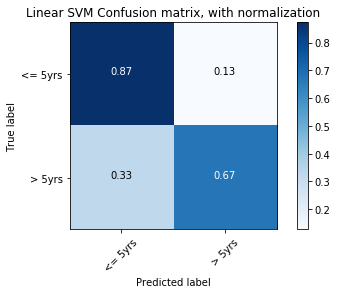

In [17]:
eval(model_lsvm, 'Linear SVM')

In [18]:
# MLP

print('Start training MLP...')
model_mlp = MLPClassifier(hidden_layer_sizes=(100,),
                          random_state=42,
                          verbose=True)
model_mlp.fit(X_train_scaled, y_train)

print('Saving MLP model...')
joblib.dump(model_mlp, 'model_mlp.pickle')

Start training MLP...
Iteration 1, loss = 0.42750421
Iteration 2, loss = 0.36988109
Iteration 3, loss = 0.33604909
Iteration 4, loss = 0.32372977
Iteration 5, loss = 0.31807650
Iteration 6, loss = 0.31409208
Iteration 7, loss = 0.31158577
Iteration 8, loss = 0.30973613
Iteration 9, loss = 0.30821208
Iteration 10, loss = 0.30691492
Iteration 11, loss = 0.30576719
Iteration 12, loss = 0.30436305
Iteration 13, loss = 0.30374471
Iteration 14, loss = 0.30296372
Iteration 15, loss = 0.30222045
Iteration 16, loss = 0.30142099
Iteration 17, loss = 0.30048763
Iteration 18, loss = 0.30005455
Iteration 19, loss = 0.29920485
Iteration 20, loss = 0.29870444
Iteration 21, loss = 0.29802381
Iteration 22, loss = 0.29736079
Iteration 23, loss = 0.29693438
Iteration 24, loss = 0.29620528
Iteration 25, loss = 0.29556405
Iteration 26, loss = 0.29501563
Iteration 27, loss = 0.29433942
Iteration 28, loss = 0.29371609
Iteration 29, loss = 0.29320278
Iteration 30, loss = 0.29275751
Iteration 31, loss = 0.2920

/Users/doyubkim/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['model_mlp.pickle']

Training set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.94      0.88      0.91    131888
      > 5yrs       0.77      0.87      0.82     62700

   micro avg       0.88      0.88      0.88    194588
   macro avg       0.85      0.88      0.86    194588
weighted avg       0.88      0.88      0.88    194588

Test set evaluation
              precision    recall  f1-score   support

     <= 5yrs       0.90      0.84      0.87     56342
      > 5yrs       0.71      0.80      0.75     27054

   micro avg       0.83      0.83      0.83     83396
   macro avg       0.80      0.82      0.81     83396
weighted avg       0.84      0.83      0.83     83396

Confusion matrix, without normalization


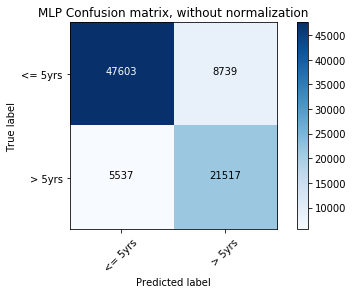

Normalized confusion matrix


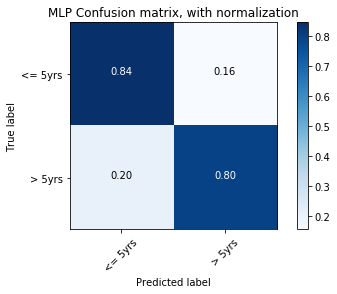

In [19]:
eval(model_mlp, 'MLP', X_train_scaled, X_test_scaled)